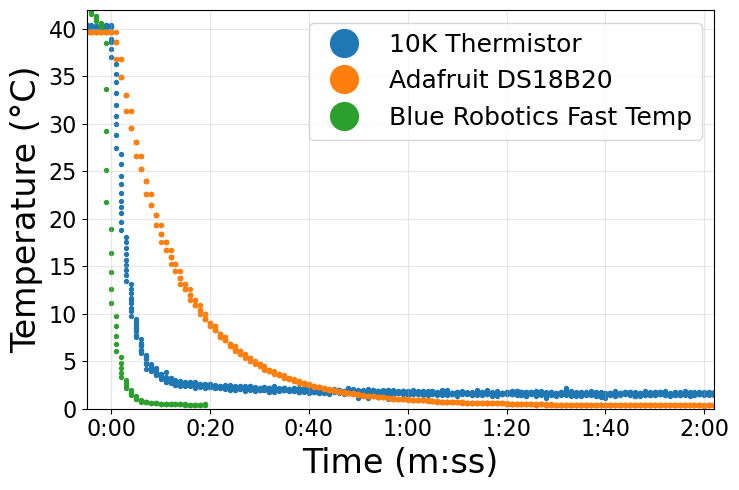

CTD fastBR T60: 0.00s | initial=40.00, final=0.48, target=16.29
Thermistor T60: 3.00s | initial=40.00, final=1.93, target=17.16
DS18B20 T60: 12.00s | initial=40.00, final=0.38, target=16.23

CTD fastBR T90: 2.00s | initial=40.00, final=0.48, target=4.43
Thermistor T90: 7.00s | initial=40.00, final=1.93, target=5.73
DS18B20 T90: 31.00s | initial=40.00, final=0.38, target=4.34


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines

sensor_colors = {
    "Thermistor": "tab:blue",
    "DS18B20": "tab:orange",
    "CTD fastBR": "tab:green"
}

colors = {
    "CTD fastBR": "tab:blue",
    "Thermistor": "tab:orange",
    "DS18B20": "tab:green"
}

def compute_response_time(time, temp, label, final_window, percent=60,
                          initial_override=None, final_override=None):
    """
    Compute T60 response time for a sensor based on first crossing (no interpolation).
    """
    # Initial temp
    if initial_override is not None:
        initial_temp = initial_override
    else:
        pre_plunge = temp[time < 0]
        if len(pre_plunge) < 5:
            print(f"Warning: Not enough pre-plunge data for {label}")
            return np.nan
        initial_temp = pre_plunge.iloc[-5:].mean()

    # Final temp
    if final_override is not None:
        final_temp = final_override
    else:
        mask_final = (time >= final_window[0]) & (time <= final_window[1])
        final_temps = temp[mask_final]
        if len(final_temps) < 5:
            print(f"Warning: Not enough final-window data for {label}")
            return np.nan
        final_temp = final_temps.mean()

    # Target temperature
    T_target = initial_temp + (percent / 100.0) * (final_temp - initial_temp)

    # Post-plunge time/temp
    mask_post = time >= 0
    time_post = time[mask_post]
    temp_post = temp[mask_post]

    if final_temp > initial_temp:
        crossed = temp_post >= T_target
    else:
        crossed = temp_post <= T_target

    if crossed.any():
        t_response = time_post[crossed].iloc[0]
        print(f"{label} T{int(percent)}: {t_response:.2f}s | initial={initial_temp:.2f}, final={final_temp:.2f}, target={T_target:.2f}")
        return t_response
    else:
        print(f"{label} did not reach T{int(percent)} within available data.")
        return np.nan

final_temp_windows = {
    "CTD fastBR": (10, 20),
    "Thermistor": (35, 45),
    "DS18B20": ((60+35), (60+45))
}

testName = "testTwelveTempResponse"

tempLogger = "2025-07-30.csv"
ctd = "2025-07-30T11-27-36.csv" # first 
ctd = "2025-07-30T13-08-47.csv"

# Load data
df_tempLogger = pd.read_csv(tempLogger)
df_ctd = pd.read_csv(ctd)

# Convert 'time' columns to datetime
df_tempLogger["time"] = pd.to_datetime(df_tempLogger["time"])
df_ctd["time"] = pd.to_datetime(df_ctd["time"])

# Calculate elapsed time from start
df_tempLogger["elapsed_sec"] = (df_tempLogger["time"] - df_tempLogger["time"].iloc[0]).dt.total_seconds()
df_ctd["elapsed_sec"] = (df_ctd["time"] - df_ctd["time"].iloc[0]).dt.total_seconds()

# --- MANUAL indices for start of icewater  ---
therm_drop_idx  = 2410 # second try 555
dallas_drop_idx = 2410 # second try 555
fastBR_drop_idx = 560  # second try 25
# ---------------------------------------------

# Get plunge times
therm_drop_time = df_tempLogger["elapsed_sec"].iloc[therm_drop_idx]
dallas_drop_time = df_tempLogger["elapsed_sec"].iloc[dallas_drop_idx]
fastBR_drop_time = df_ctd["elapsed_sec"].iloc[fastBR_drop_idx]

# Shift time to plunge = 0
df_tempLogger["therm_time_shifted"] = df_tempLogger["elapsed_sec"] - therm_drop_time
df_tempLogger["dallas_time_shifted"] = df_tempLogger["elapsed_sec"] - dallas_drop_time
df_ctd["fastBR_time_shifted"] = df_ctd["elapsed_sec"] - fastBR_drop_time

# --- Plot ---
fig, ax = plt.subplots(figsize=(7.5, 5))  # Landscape layout for time series

index = 6
size = 8  # Marker size for scatter plot

# Thermistor data
therm_plot = ax.scatter(df_tempLogger["therm_time_shifted"][index:], df_tempLogger["thermTemp"][index:], 
                        label="Thermistor", s=size, color=sensor_colors["Thermistor"])

# DS18B20 data
dallas_plot = ax.scatter(df_tempLogger["dallas_time_shifted"][index:], df_tempLogger["slowDallasTemp"][index:], 
                         label="Adafruit DS18B20", s=size, color=sensor_colors["DS18B20"])

# fastBRTemp sensor data
BRRange = slice(500, 655)
br_plot = ax.scatter(df_ctd["fastBR_time_shifted"].iloc[BRRange],
                     df_ctd["fastBRTemp"].iloc[BRRange],
                     label="Blue Robotics", s=size, color=sensor_colors["CTD fastBR"])

# Format x-axis ticks
ticks = np.arange(0, 180, 20)
ax.set_xticks(ticks)

def format_seconds(sec):
    m = int(sec) // 60
    s = int(sec) % 60
    sign = "-" if sec < 0 else ""
    return f"{sign}{abs(m)}:{abs(s):02}"

ax.set_xticklabels([format_seconds(t) for t in ticks], fontsize=16)

# Y-axis ticks and labels
ax.set_yticks(np.arange(0, 45, 5))
ax.set_ylim(0, 42)
ax.tick_params(axis='y', labelsize=16)

# Labels (no title)
ax.set_xlabel("Time (m:ss)", fontsize=24)
ax.set_ylabel("Temperature (°C)", fontsize=24)

# Custom legend with large circle markers for readability
markersize = 20
legend_handles = [
    mlines.Line2D([], [], color=sensor_colors["Thermistor"], marker='o', linestyle='None', markersize=markersize, label="10K Thermistor"),
    mlines.Line2D([], [], color=sensor_colors["DS18B20"], marker='o', linestyle='None', markersize=markersize, label="Adafruit DS18B20"),
    mlines.Line2D([], [], color=sensor_colors["CTD fastBR"], marker='o', linestyle='None', markersize=markersize, label="Blue Robotics Fast Temp")
]
ax.legend(handles=legend_handles, fontsize=18)

# Grid and limits
ax.grid(alpha=0.3)
ax.set_xlim(-5, 122)

plt.tight_layout()
plt.savefig(f"{testName}_mainplot.png", dpi=600)
plt.show()

# known temperature
known_initial_temp = 40.0
known_final_temp = 0.5

# T63
t63_fastBR = compute_response_time(
    df_ctd["fastBR_time_shifted"], df_ctd["fastBRTemp"],
    "CTD fastBR", final_temp_windows["CTD fastBR"],
    percent=60, initial_override=known_initial_temp)

t63_therm = compute_response_time(
    df_tempLogger["therm_time_shifted"], df_tempLogger["thermTemp"],
    "Thermistor", final_temp_windows["Thermistor"],
    percent=60, initial_override=known_initial_temp)

t63_dallas = compute_response_time(
    df_tempLogger["dallas_time_shifted"], df_tempLogger["slowDallasTemp"],
    "DS18B20", final_temp_windows["DS18B20"],
    percent=60, initial_override=known_initial_temp)

print() # spacing 
# T90
t90_fastBR = compute_response_time(
    df_ctd["fastBR_time_shifted"], df_ctd["fastBRTemp"],
    "CTD fastBR", final_temp_windows["CTD fastBR"],
    percent=90, initial_override=known_initial_temp)

t90_therm = compute_response_time(
    df_tempLogger["therm_time_shifted"], df_tempLogger["thermTemp"],
    "Thermistor", final_temp_windows["Thermistor"],
    percent=90, initial_override=known_initial_temp)

t90_dallas = compute_response_time(
    df_tempLogger["dallas_time_shifted"], df_tempLogger["slowDallasTemp"],
    "DS18B20", final_temp_windows["DS18B20"],
    percent=90, initial_override=known_initial_temp)